In [30]:
# Imports & paths
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import cv2

plt.rcParams["figure.dpi"] = 140

# Image path
IMG_PATH = Path("/scratch/hdharmen/ASU/CSE 507/data/jsrt/Practice_DICOM/_png/JPCLN002.png")


# Output folder
OUT = Path("/scratch/hdharmen/ASU/CSE 507/data/Otsu_output")
OUT.mkdir(parents=True, exist_ok=True)
print("Output dir:", OUT.resolve())


Output dir: /scratch/hdharmen/ASU/CSE 507/data/Otsu_output


In [31]:
# Load grayscale
img = cv2.imread(str(IMG_PATH), cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"Could not load {IMG_PATH}")

print(f"Loaded: {IMG_PATH.name}, dtype={img.dtype}, shape={img.shape}")

# Adding Gaussian Blur
blur = cv2.GaussianBlur(img, (5,5), sigmaX=0)


Loaded: JPCLN002.png, dtype=uint8, shape=(2048, 2048)


In [32]:
# Otsu manual and OpenCV

def otsu_manual(image, bins_num=256):
    hist, bin_edges = np.histogram(image, bins=bins_num, range=(0,255))
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.

    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]

    eps = np.finfo(np.float64).eps
    mean1 = np.cumsum(hist * bin_mids) / np.clip(weight1, eps, None)
    mean2 = (np.cumsum((hist * bin_mids)[::-1]) / np.clip(weight2[::-1], eps, None))[::-1]

    inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
    idx = np.argmax(inter_class_variance)
    threshold = bin_mids[:-1][idx]
    return threshold

# Manual
t_manual = otsu_manual(img)

# OpenCV
t_cv_orig, otsu_orig = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
t_cv_blur, otsu_blur = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

print(f"Manual Otsu threshold: {t_manual:.2f}")
print(f"OpenCV Otsu (original): {t_cv_orig:.2f}")
print(f"OpenCV Otsu (blurred): {t_cv_blur:.2f}")


Manual Otsu threshold: 110.07
OpenCV Otsu (original): 110.00
OpenCV Otsu (blurred): 110.00


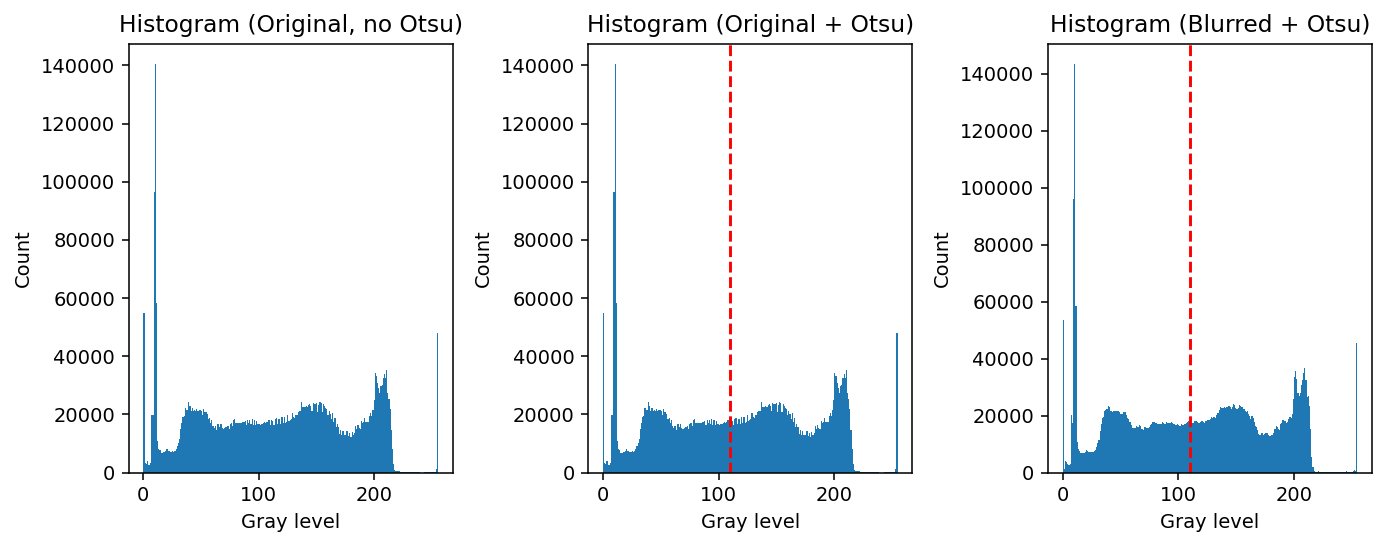

In [33]:
# Histograms

fig, axes = plt.subplots(1,3, figsize=(10,4), tight_layout=True)

# Raw histogram
axes[0].hist(img.ravel(), bins=256, range=(0,255))
axes[0].set_title("Histogram (Original, no Otsu)")
axes[0].set_xlabel("Gray level"); axes[0].set_ylabel("Count")

# Otsu-marked histogram
axes[1].hist(img.ravel(), bins=256, range=(0,255))
axes[1].axvline(t_cv_orig, color="r", linestyle="--")
axes[1].set_title("Histogram (Original + Otsu)")
axes[1].set_xlabel("Gray level"); axes[1].set_ylabel("Count")

# Otsu-blur histogram
axes[2].hist(blur.ravel(), bins=256, range=(0,255))
axes[2].axvline(t_cv_blur, color="r", linestyle="--")
axes[2].set_title("Histogram (Blurred + Otsu)")
axes[2].set_xlabel("Gray level"); axes[2].set_ylabel("Count")

plt.savefig(OUT / "histogram_comparison.png", bbox_inches="tight")
plt.show()


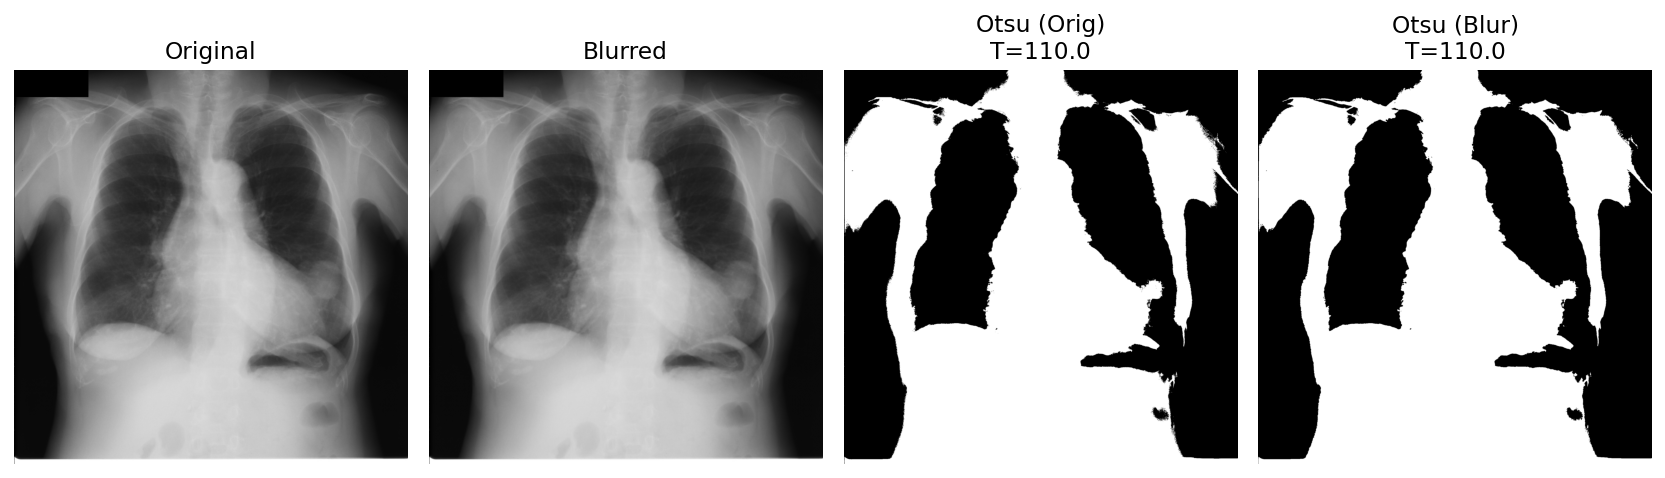

In [34]:
# Images

fig, axes = plt.subplots(1,4, figsize=(12,3.5), tight_layout=True)

axes[0].imshow(img, cmap="gray")
axes[0].set_title("Original"); axes[0].axis("off")

axes[1].imshow(blur, cmap="gray")
axes[1].set_title("Blurred"); axes[1].axis("off")

axes[2].imshow(otsu_orig, cmap="gray")
axes[2].set_title(f"Otsu (Orig)\nT={t_cv_orig:.1f}"); axes[2].axis("off")

axes[3].imshow(otsu_blur, cmap="gray")
axes[3].set_title(f"Otsu (Blur)\nT={t_cv_blur:.1f}"); axes[3].axis("off")

plt.savefig(OUT / "results_montage.png", bbox_inches="tight")
plt.show()

# Save individual results
#cv2.imwrite(str(OUT / "otsu_on_original.png"), otsu_orig)
#cv2.imwrite(str(OUT / "otsu_on_blur.png"), otsu_blur)


In [38]:
def plot_hist_triptych(image_u8, threshold, title_base, outpath, bins=256):

    # raw histogram (counts)
    hist_counts, bin_edges = np.histogram(image_u8.ravel(), bins=bins, range=(0,255))
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    # normalized histogram
    hist_norm = hist_counts.astype(np.float64)
    if hist_norm.max() > 0:
        hist_norm /= hist_norm.sum()  

    # binary image via threshold
    _, bin_img = cv2.threshold(image_u8, int(round(threshold)), 255, cv2.THRESH_BINARY)
    count_0 = int((bin_img == 0).sum())
    count_255 = int((bin_img == 255).sum())

    # plotting
    fig, axes = plt.subplots(1, 3, figsize=(12, 3.6), tight_layout=True)

    # raw counts
    axes[0].hist(image_u8.ravel(), bins=bins, range=(0,255))
    axes[0].axvline(threshold, color="r", linestyle="--", linewidth=1.5)
    axes[0].set_title(f"{title_base}: Raw histogram")
    axes[0].set_xlabel("Gray level"); axes[0].set_ylabel("Count")

    # normalized
    axes[1].plot(bin_mids, hist_norm)  # line plot = cleaner for probs
    axes[1].axvline(threshold, color="r", linestyle="--", linewidth=1.5)
    axes[1].set_title(f"{title_base}: Normalized histogram")
    axes[1].set_xlabel("Gray level"); axes[1].set_ylabel("Probability")

    # binary histogram
    axes[2].bar([0, 255], [count_0, count_255], width=20)
    axes[2].set_xlim(-10, 265)
    axes[2].set_xticks([0, 255])
    axes[2].set_title(f"{title_base}: Binary histogram")
    axes[2].set_xlabel("Gray level"); axes[2].set_ylabel("Count")
    axes[2].text(0, count_0*1.02, f"{count_0:,}", ha="center", va="bottom")
    axes[2].text(255, count_255*1.02, f"{count_255:,}", ha="center", va="bottom")

    plt.savefig(outpath, bbox_inches="tight")
    plt.show()

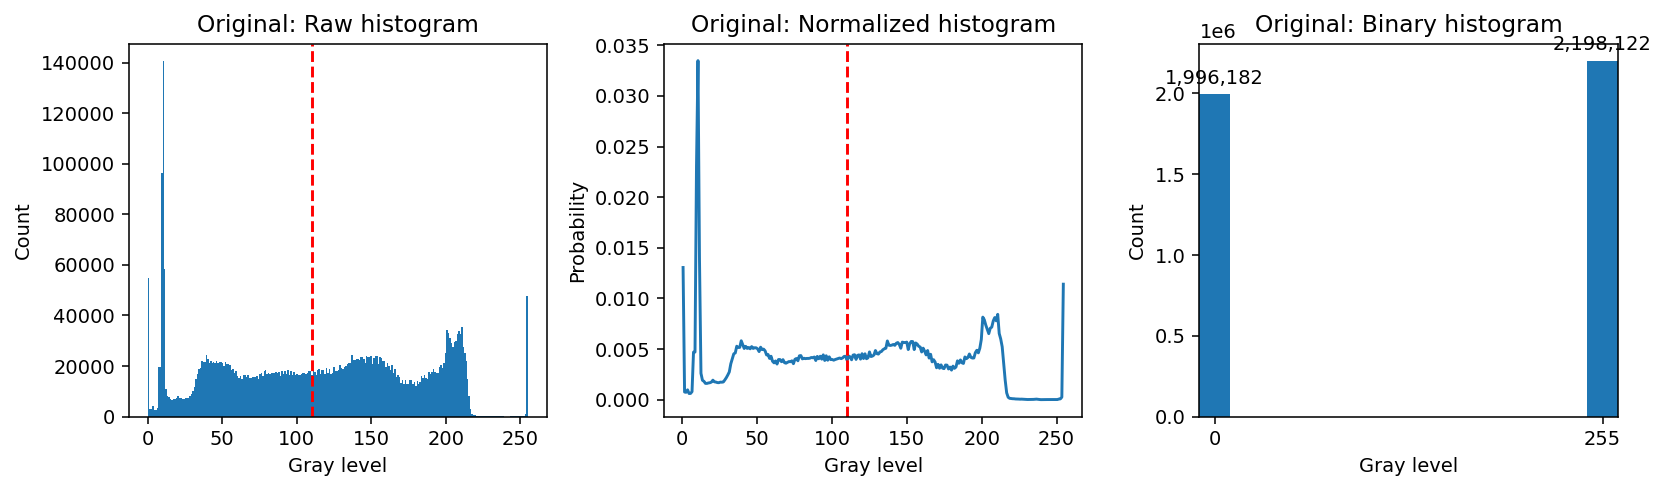

In [39]:
# Original image histograms (raw, normalized, and binary-after-Otsu)
plot_hist_triptych(
    image_u8=img,
    threshold=t_cv_orig,
    title_base="Original",
    outpath=OUT / "histograms_original_triptych.png"
)
